# Executive Summary

This project aims to utilise a SpikerBox to record EOG signals and then use a classifier to classify different eye movements to control the function of Spotify. This project aims to enable individuals with limited mobility to interact with the Spotify app hands-free, thereby enhancing their music listening experience.

The key findings from this project show how we can effectively use eye movements as a form of input modality. After testing of feature selection different classifiers methods and careful evaluation, our team came to a conclusion to use a frequency filter of 3-15 Hz and a random forest model trained on a comprehensive set of features extracted from the tsfeatures package, using a threshold value for standard deviation to detect events. This framework obtained an accuracy of 94.86% with 5-fold cross-validation and a round trip latency of approximately 7.78 ms. However, the electrodes must be worn in specific positions that also create an inconvenience for individuals with limited mobility.



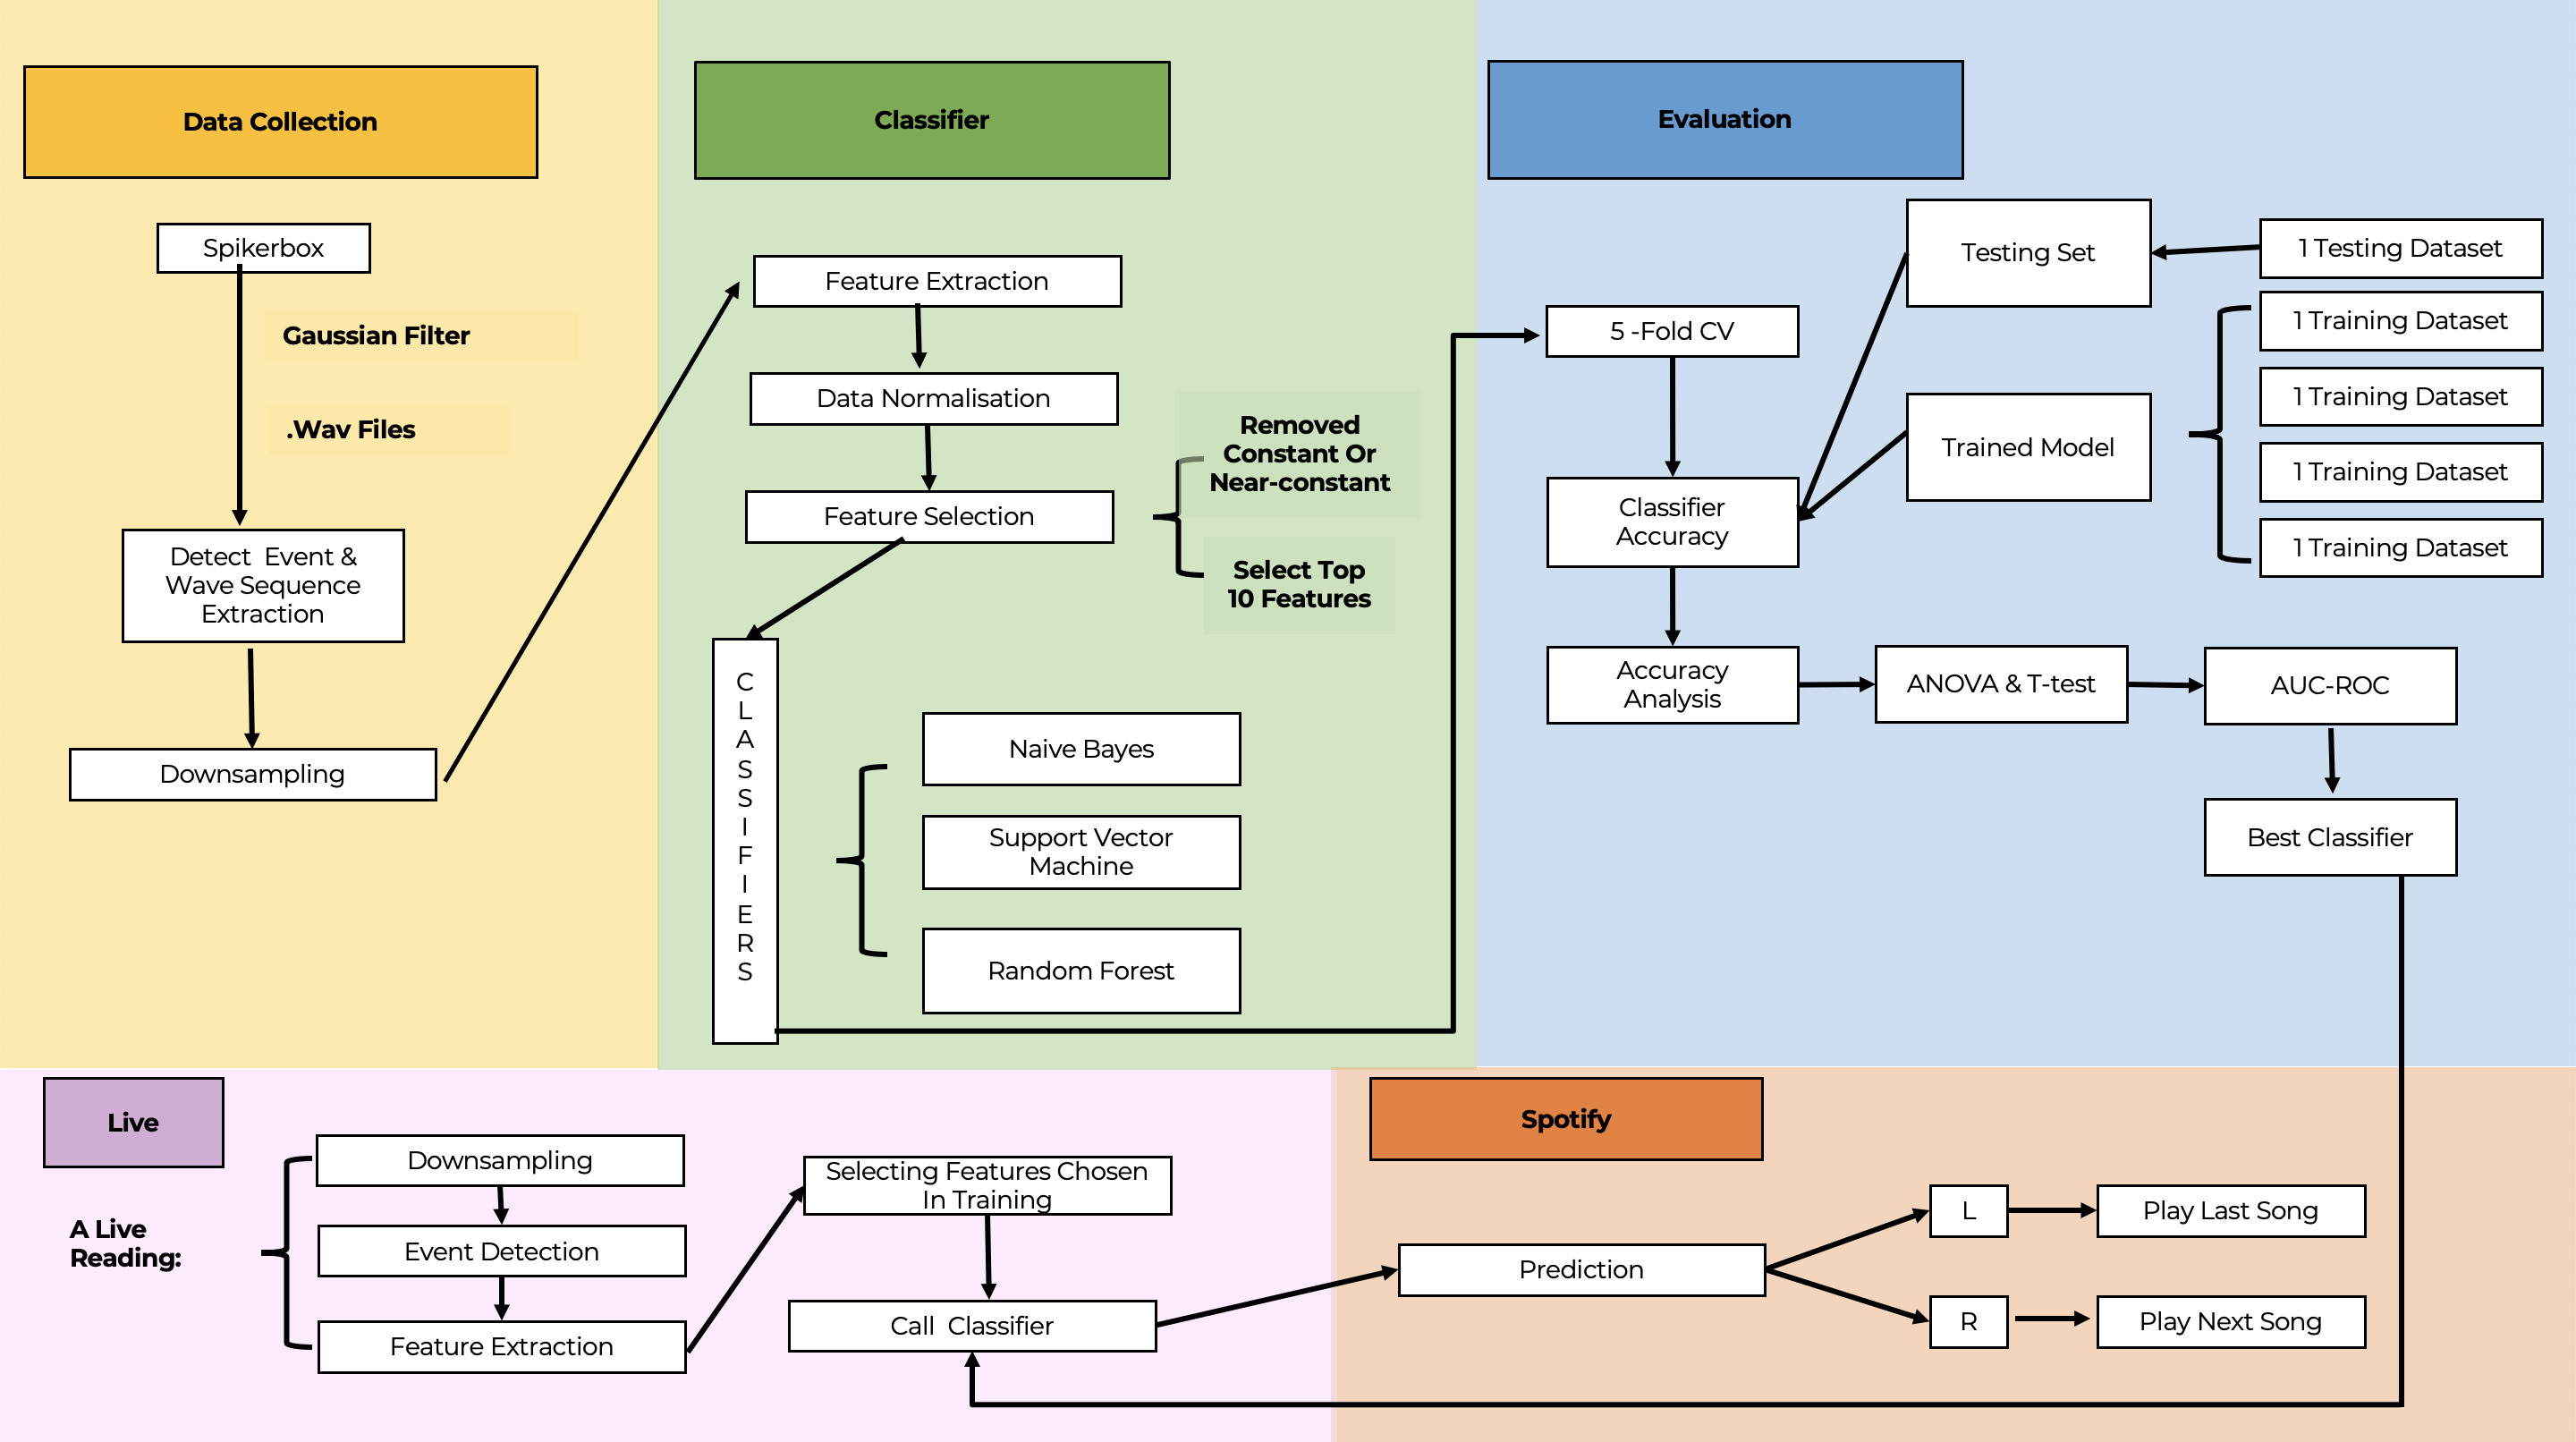

# 1. Introduction

The development of technologies to interact with digital systems using different human signals has seen increasing progress in recent years. In this project, a multidisciplinary team of physics and data science students collaborated to develop a method to control music playback using eye signals facilitated by the SpikerBox. The project aimed to provide a convenient and accessible way for people with mobility disabilities and physical impairments to control music playback without the need for traditional input devices. Music has always been a universal form of entertainment and expression, as well as a source of comfort. For people with physical disabilities, controlling the user interface can be challenging, especially with limited mobility and when confined to a hospital bed or housebound.

The human eye exhibits bioelectromagnetic characteristics resulting in an electric potential between the cornea and retina, forming an electric dipole. Movement in the eye's orientation can induce a measurable change in the electric field, producing an electrooculogram(EOG) signal. Through electrodes, this signal can be read by the brain SpikerBox which will produce a waveform of the EOG signal. The EOG signal provides insights into eye-related phenomena and the dynamics and functionality of the eye, allowing for different actions, such as looking left or right, to be differentiated. To classify these eye movements in wave sequence, machine learning is necessary to be involved in this project. 



# 2. Method
## 2.1 DATA COLLECTION
Data collection for the classifier training was performed by creating .wav files which could then be put through the training code to extract features of known values. Using the Spikerstream software, it was possible to record events and time stamp relative movements, which could then be annotated as ‘Left’ or ‘Right’ eye movements. Approximately thirty files were created, each with a range of eye movements and a number of signals from anywhere between three and fifteen. Using the spiker box in the same configuration as in the final product ensured continuity and minimal confusion of the classifier. Minimising sources of noise were also taken into account by not having any main power connected to the computer or around the spiker box, as this would cause electromagnetic interference and create a noisy signal. 

## 2.2 Data Propressing
Our training dataset contains multiple folders, each holding a .wav file and a text file. The .wav file comprises multiple events from 3 to 15 events per wave file to get a variety of states of the eye. The text file has the start timings of the event along with the movement(Left or Right), which enables us to find the event in the .wav file and populate the labels. We extract the values of the wave file till 750 ms after the start time; this creates our dataset containing the labels for each corresponding event. Now we can pass this dataset on further for feature extraction.

## 2.3 Event Detection
To identify events, we tested multiple approaches; using standard deviation (SD), number of median crossing and gradient in the interval. Of the three, the gradient gave us the most unreliable results, routinely misclassifying events. Both SD and median crossing methods work by calculating their respective values in the current window (of length 500 ms) and checking whether they cross a certain threshold value. Both methods were compared in terms of accuracy, correctly returning the start of the event at every window. However, there was a slight difference in latency. After testing both methods on the live model, we found that, on average of 20 trials, the SD method took 7.7724 ms at each interval and 7.8707 ms for the median crossing. Doing a two-sample t-test on these values, we found evidence of a statistical difference between these two methods (p-value = 0.103). Therefore, we went with the standard deviation method.


Our final model marks the time when the SD for an interval crosses 35, which we found was the optimal value after checking all threshold values from 10 to 50 and observing the value of SD when we had an event. Then we note down all ‘Y’ values till the SD falls below 35; this sequence is then passed onto our Random forest classifier for feature extraction and subsequent prediction.

## 2.4 Downsampling
In order to mitigate the challenges arising from a large length of wave sequence, we implemented downsampling to reduce the sample rate. The process of downsampling reduces the management burden in the dataset and the calculation burden in feature extraction. In this downsampling, we selected one data point out of every 350 wave values as a new sample rate.


In [1]:
# EVALUATION
import os
import re
import librosa
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

from scipy.io import wavfile
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt

wave_seq = pd.read_csv("Training_X.csv") 
label = pd.read_csv("Training_Y.csv")
label.index += 1
wave_seq=wave_seq.dropna()

In [2]:


def downsample_dataframe(dataframe, new_sample_rate):
    downsampling_factor = int(dataframe.shape[0] / new_sample_rate)
    downsampled_dataframe = dataframe.iloc[::downsampling_factor, :]
    return downsampled_dataframe

downsampled_df = downsample_dataframe(wave_seq, 350)



## 2.5 Feature extraction
We conducted feature extraction to transform the wave sequence into numerical features for each eye movement. Instead of straightforwardly importing the wave sequence, fitting numerical features in the classifier would help the classifier recognise the pattern underlying the wave sequence and make a more accurate prediction. 239 features have been maintained after excluding all features, including null values. The result of our feature extraction provides more informative data for the classifier.


In [3]:

from tsfresh import extract_features 
from tsfresh.feature_extraction import ComprehensiveFCParameters


ext_feature_df = extract_features(downsampled_df,column_id="Id",column_sort="Time",
                                  default_fc_parameters=ComprehensiveFCParameters(),
                                  n_jobs=0)
ext_feature_clean = ext_feature_df.dropna(axis = 1, how = "any")


Feature Extraction: 100%|███████████████████████| 73/73 [00:03<00:00, 22.18it/s]


## 2.6 Normalisation
Since computed features are measured on varying scales, the effect of the attributes would differ by their scale size. Compared with features measured in smaller scales, features with larger scales would have greater significance to the classifier. And then resulted in an inaccurate classification by our classifier. Hence, we performed normalisation along each feature to ensure equal contribution from all features to our classifiers.


In [4]:

warnings.filterwarnings('ignore')

from sklearn.preprocessing import minmax_scale
cols = ext_feature_clean.select_dtypes(np.number).columns
ext_feature_clean[cols] = minmax_scale(ext_feature_clean[cols])

ext_feature_clean["label"] = label

## 2.7 Feature selection
The feature selection process has guaranteed a more efficient modelling process later on. The dataset contains up to 239 numerical features, resulting in a high-dimensional dataset that enhances the accuracy of the classifier. However, these large amounts of features could lead to overfitting in our classifier. Hence, we used two feature selection strategies to filter relatively informative features to fit our classifiers.
Firstly, we utilised variance to eliminate features that contain similar or single values across all observations in the dataset. These features offer less valuable information for generating a highly accurate classifier, and since we have a large number of features, we can safely remove them. 
Secondly, we only retain the top 10 features that contribute most to our target label. By selecting limited features, the training time of the model and the dimensionality of the dataset have been effectively reduced with sacrificing minor predictive powers.


In [5]:

import pandas as pd
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import VarianceThreshold

main = ext_feature_clean
X = main.drop(columns="label")
y = main["label"]
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Remove constant or near-constant features
filter1 = VarianceThreshold(threshold=0.01)
X_filter1 = filter1.fit_transform(X)
concol1 = [column for column in X.columns if column not in X.columns[filter1.get_support()]]
X_1 = X.drop(concol1,axis=1)


In [6]:
# Select the top k features using SelectKBest and f_regression
from sklearn.feature_selection import chi2, f_regression

filter2 = SelectKBest(score_func=f_regression,k=10)
X_filter2 = filter2.fit_transform(X_1, y_encoded)
filter_inx = filter2.get_support(indices=True)

concol2 = [column for column in X_1.columns 
          if column not in X_1.columns[filter_inx]]

#X_1 = X.drop(concol1,axis=1)
X_2 = X_1.drop(concol2,axis=1)

In [7]:
# selected features
selected_features = X_2.columns

# selected_features_df
ind = ['label'] + list(selected_features)
selected_features_df = main[ind]


In [8]:

# EVALUATION
import os
import re
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier



In [9]:
from sklearn import svm

X = selected_features_df.drop(columns="label")
y = selected_features_df["label"]

cv = RepeatedKFold(n_splits=10, n_repeats=50, random_state=3888)

gnb = GaussianNB(var_smoothing=1e-5)
rf = RandomForestClassifier()
svm = svm.NuSVC(kernel='poly', degree=3)

#scoring
svm_scores = cross_val_score(svm, X, y, cv=cv,scoring='accuracy')
rf_scores = cross_val_score(rf, X, y, cv=cv,scoring='accuracy')
nb_scores = cross_val_score(gnb, X, y, cv=cv,scoring='accuracy')


# 3. EVALUATION

To identify the most suitable classifier for eye movement, we measured the performance of the product based on graphical, qualitative and quantitative metric given our collected dataset. 

## 3.1 Electronic position(Graphical)
In order to ensure the classifier had the best opportunity to work accurately and effectively, it required clean signals from the SpikerBox. From a physics perspective, there were different ways to clean up the signal without the need for any coding or software influence. Electrode placement was one area where it was very important to have the right positioning in order to isolate the eye movements that were the target of the analysis. Different electrode placement configurations were tested by evaluating the size and clarity of the signal relative to the background noise, with different configurations either being noisy or not showing the desired eye movement. This signal could then be passed through a filter in order to further clarify it for the classifier.

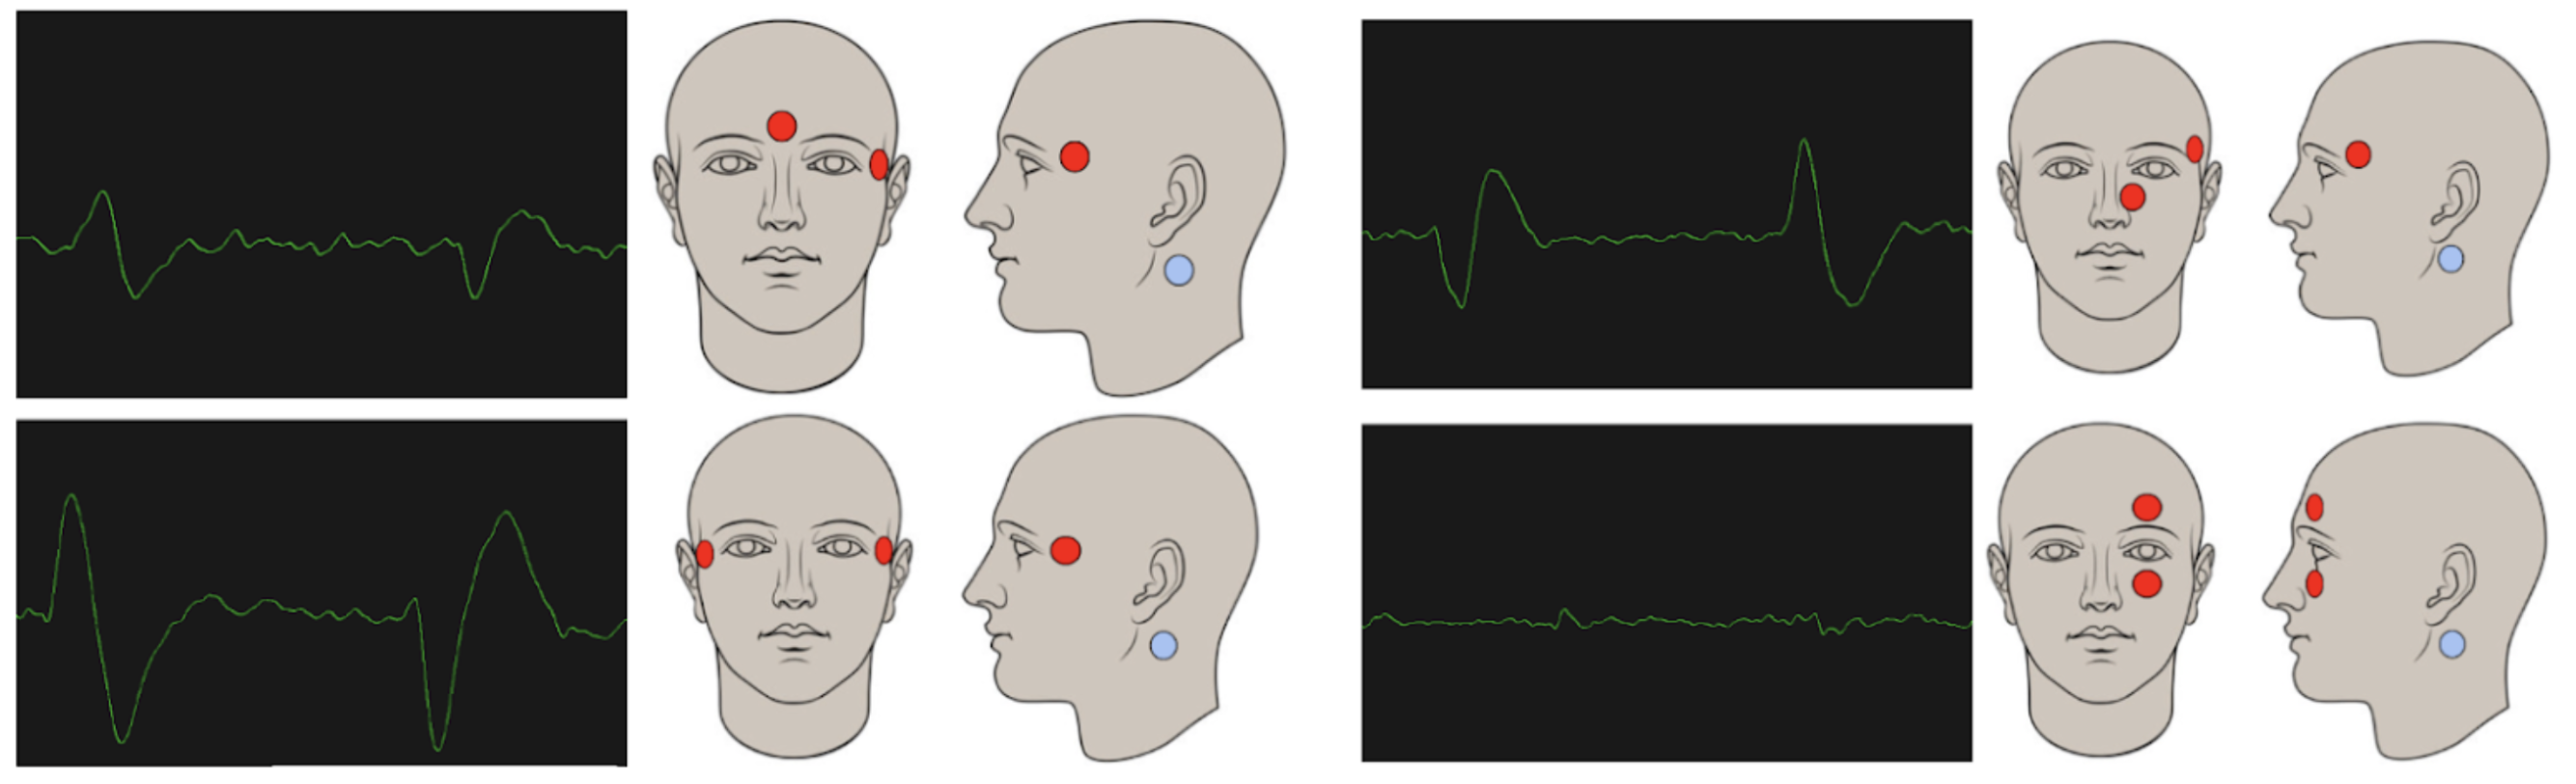

## 3.2 Noisy
Once the signal was isolated, it could be cleaned up further using a frequency filter to remove any noise. It was noticed that when higher frequencies were allowed to be used in the signal, the noise level was quite high. By limiting the frequency at which the sample is measured to lower frequencies, the noise of the signal became much lower and was easier for the classifier to detect. A range of frequencies were analysed to identify the frequency range with the lowest amount of noise relative to the signal. Using both methods of signal clarification meant that the data provided was as clean as possible and allowed for more accurate signal extraction and classification. 

## 3.3 Accuracy(Quantitative)
We implement 10 fold cross validation with 50 repeats on three classifiers - Support Vector Machine, Random Forest, and Gaussian Naive Bayes to evaluate. Their performance on the classification task is notable as all of their accuracies are above 85%. Among three classifiers,  Random Forest performed the highest average accuracy of 93.5% that demonstrated its significant effectiveness in this classification task. While random forest reduces the risk of being overfit, it also has an advantage on noisy data because it is robust. Naive Bayes followed closely with an average accuracy of 86.2%, and can be trained and evaluated relatively faster than other classifiers. We observed the lowest accuracy in Support Vector Machine that is 85.3%, although its ability to handle complex decision boundaries could help us generalise well on new samples from wave sequences and it might perform better when multiple people start using our product.


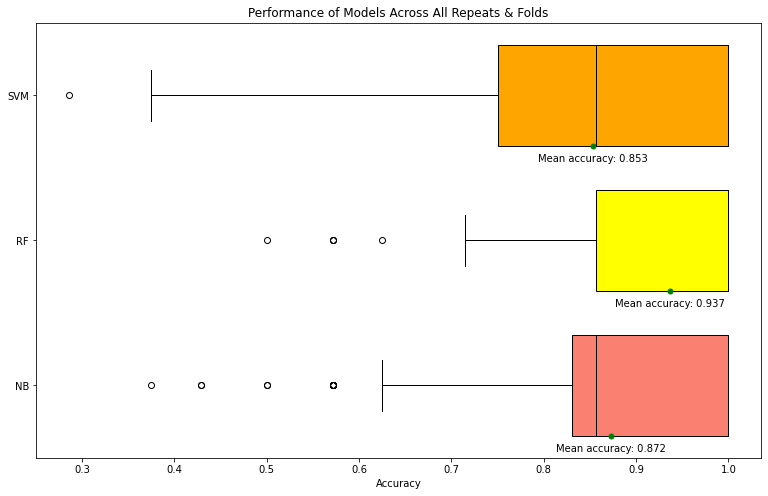

In [10]:

model = [nb_scores, rf_scores, svm_scores]
model_name = ['NB', 'RF', 'SVM']
colors = ['salmon','yellow', 'orange']

fig, ax = plt.subplots(figsize=(13, 8))
boxplot = ax.boxplot(model, labels=model_name, patch_artist=True, vert=False, widths=0.7)

for box, color in zip(boxplot['boxes'], colors):
    box.set(facecolor=color)

mean_scores = [np.mean(scores) for scores in model]
medians = [item.get_ydata()[0] for item in boxplot['medians']]

for i, (mean_score, median) in enumerate(zip(mean_scores, medians)):
    ax.text(mean_score, median - 0.05,
            f'Mean accuracy: {mean_score:.3f}',
            ha='center', va='top')
    ax.plot(mean_score, median, marker='o', markersize=5, color='green')
    boxplot['medians'][i].set_color('black')
    
ax.set_xlabel('Accuracy')
ax.set_title('Performance of Models Across All Repeats & Folds')
plt.show()


## 3.4 T-test

The low p-value indicates against the null hypothesis since p-value is smaller than 0.05, suggesting that at least one of the classifiers performs significantly better than the others. According to the accuracy, we chose the mean of random forest and mean of naive bayes to perform  a t test, the t-test results show a significant difference between the naive bayes and random forest classifiers, with a t-statistic of -12.945 and small p-value of 2.97e-33. This indicates a highly significant difference in their performance.



In [11]:
from sklearn import metrics
from scipy.stats import ttest_rel
from scipy.stats import f_oneway

anova_stat, anova_p_value = f_oneway(nb_scores, rf_scores, nb_scores)

print("ANOVA Test Results:")
print("F-statistic:", anova_stat)
print("p-value:", anova_p_value)
print("--------------------")
t_stat, p_value = ttest_rel(nb_scores, rf_scores)
print("T-Test     Results:")
print("T-Statistic:", t_stat)
print("P-Value:", p_value)

ANOVA Test Results:
F-statistic: 53.360130969275865
p-value: 4.118587395468326e-23
--------------------
T-Test     Results:
T-Statistic: -12.442065479287313
P-Value: 3.841536425996017e-31


## 3.5 AUC-ROC

In terms of discrimination ability, the naive bayes classifier achieved an AUC-ROC score of 0.9736, while the random forest classifier achieved a remarkable score of 0.9881. These scores indicate their strong ability to distinguish between classes. Overall, both classifiers demonstrated excellent performance in classification, with the random forest classifier showing a slightly better AUC-ROC score. Random forest machine learning method shows  the highest accuracy  to support our hypothesis. So we can conclude that there is a significant difference in the performance of the classifiers.


In [12]:
nb_probs = gnb.fit(X, y).predict_proba(X)
nb_auc = metrics.roc_auc_score(y, nb_probs[:, 1])

rf_predictions = rf.fit(X, y).predict_proba(X)
rf_auc = metrics.roc_auc_score(y, rf_predictions[:, 1])

print("Naive Bayes   AUC-ROC:", nb_auc)
print("Random Forest AUC-ROC:", rf_auc)

Naive Bayes   AUC-ROC: 0.973604826546003
Random Forest AUC-ROC: 1.0



## 3.6 User experience

To evaluate the user experience, usability and convenience of the product to control music playback will be considered. The device is fairly easy to set up, however would prove inconvenient for the products intended target audience who would need assistance to place the electrodes. Some might also consider the wearing of electrodes to be uncomfortable and invasive. The length of the connecting wires, which would limit how far an individual is able to move from the brain SpikerBox.  




# 4. Result

Based on 10-fold cross-validation with 50 repeats, the performance of Random Forest(93.5%) and Naive Bayes(86.2%) is relatively better than Support Vector Machine. Combining with the t-test results, it shows that there are significant differences between naive Bayes classifier and the random forest classifier. We decided to use AUC-ROC to distinguish the prediction ability between random forest and support vector machine, and demonstrate whether there are significant differences between these two models.

From the experimental evaluation of the electrode placement, the configuration of one just below each temple was used as it resulted in the clearest signal and relatively low noise levels. In conjunction with this, a frequency filter of 3-15 Hz was found to have the lowest noise level compared to other ranges. By incorporating both of these aspects into the product, the signal clarity was optimised and allowed for a greater user experience as the electrode position is not intrusive or annoying to the wearer. 


Additionally, we also evaluated the latency of the models, The training phase of an SVM involves solving a convex optimization problem, which can be computationally intensive for large datasets. However once trained, SVMs can make predictions relatively quickly, as they rely on a subset of support vectors to classify new instances.

On the other hand, Random Forest models are an ensemble of decision trees, where each tree is built independently using random subsets of features and data. While training, Random Forests may create multiple decision trees, which can be computationally expensive, especially for large datasets or complex feature spaces.  However once trained, a random Forest can even classify instances parallelly as the trees are independent. 

However, since we get instances serially we get no benefit from the parallelism. This is seen when we calculate the time for a prediction in our model the Random Forest takes an average of 79.580 ms and the SVM takes 77.187 ms.


Our product consisted of two equipment - Spikerbox and computer. The user has to wear a Spikerbox to record the wave sequence first. Our product would import this random forest classifier and classify the eye movement for input wave sequence in real time. There are two types of classification available so far thus our product would call two corresponding functions from Spotify. When the user's eye movement direction is classified to the left, Spotify will play the last song. When it classifies to the right, Spotify will play the next song.


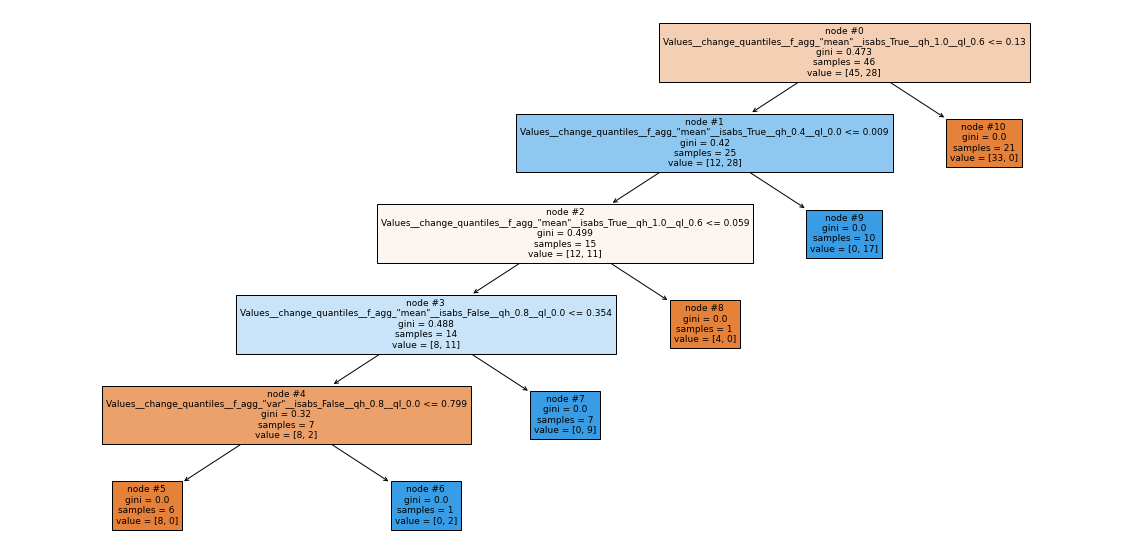

In [13]:
from sklearn import tree
tree_to_visualize = rf.estimators_[0] 
plt.figure(figsize=(20, 10))
tree.plot_tree(tree_to_visualize, feature_names=X.columns, fontsize=9, 
               filled=True, node_ids=True )
plt.show()



# 5. Discussion
Even though our final product has been implemented, there were issues present that can be improved in further development of the product. 

In the physical hardware, the electrode placement, muscle contraction strength, noise and sensor quality can affect the reliability of the system. The hardware used was quite elementary and simple for a complex situation. Due to limitations in the hardware, we could only identify limited patterns of eye movement. The movements were restricted to left, right and blink, however through the use of multiple brain Spikerbox’s, it would be possible to identify a greater range of movements. For future development of the product, more eye signals could be utilised to enable greater control of the Spotify application. 

Another limitation in the physics aspect is the types of biosignals that are detectable and extractable. The only electrode types that were available were sick on electrode pads which stick to the skin and transfer the electronic signal to the spiker box. This limitation meant that the type of product able to be developed was limited to signals that are compatible with the provided electrodes. Utilising other body movements or inputs would be useful in the further development of a product and can be tailored to the specific need of the target user. 

In terms of data science, it is necessary to include a larger dataset to train the classifier and include additional actions, such as blinking. Recognizing more complex motions introduces greater variability and may affect classification accuracy. In terms of classifiers, there are a limited number of classifiers that have been implemented and other classifiers we haven’t implemented might obtain better accuracies. We also should try more feature selection methods to search for the most appropriate subset of features, such as correlation-based feature selection.

Additionally, users would have to learn the method to use the product, and the intuitive and user-friendly interface will minimise complexity and provide an accessible system. It also creates inconvenience for our users. Extending the cable length or including a wireless functionality would enhance the flexibility and user-friendliness of the system. Additionally, the responsiveness and accuracy of the system ensure a seamless experience as delays or inaccuracies in the movement detected would impact the playback control. 

# 6. Conclusion
During this project, we developed the model of random forest based on feature extraction to classify eye movements and use them to control the various functions of Spotify. Additionally, we implemented a product that uses a brain SpikerBox to record the wave sequence of eye movement and classify them by using the developed model to control two functions of Spotify in real time.

In the future, we hope to generalise our product to work efficiently with more people and add additional functionality. Moving one's eyes up and down will increase and decrease the volume, blinking will play or pause the current track, and blinking and then moving your eyes would seek forwards and backwards in the current track.

 In order to create an effective product, members from multiple disciplines exchanged their ideas and insights with each other in hardware collection of wave data and training on the collected data to ensure a user-friendly and reliable music control experience.


# 7. Contribution

## Pengbo Teng
I focus on model construction, hypothesis testing, conclusions, and identifying limitations. I actively contributed to developing machine learning models, including feature extraction, training, and evaluation. I conducted hypothesis tests to determine the significance of differences in model performance, providing valuable insights into the effectiveness of our approach. Based on the analysis of experimental results, I write meaningful conclusions about the performance of the models in classifying movements. Additionally, I critically assessed the limitations of our product, considering factors like electrode placement and user variability. 

## Elijah Cruz
I mainly focused on creating the spotify interface, where I defined the functions to control music playback and linked the code with my spotify developer account. I contributed to the initial idea generation and brainstorming phase of the project. Furthermore, I constructed a prototype of our product where it ran as a non live version and in the presentation, I contributed to the introduction and motivations sections of our talk as well as our product demo. Additionally, I contributed to writing and editing the introduction and method sections in the final report as well as proofreading the report and checking for grammatical issues.


## Lilith Xie
As for this project, I mainly contributed to data science content and meeting minutes. The code and content for downsampling, feature extraction, data normalisation, feature selection that develops classifiers was written by me. I also rewrote and corrected the code of evaluation. Meanwhile, the slide of presentation and workflow figures were designed by me. I am also responsible for the script of data science’s evaluation analysis in presentation. And I also modifies the report and restruture the report.  

## Ned Fryar

Ned was responsible for the data collecting for the training of the classifier as well as figuring out the best electrode placement. He also worked on the analysis of the optimum frequency of the product to work on and helped out where possible for the live streaming of the data from the SpikerBox through the classifier. He was the subject in the project presentation and helped in the presentation.His contribution to the report was in the data collection and discussion aspect.

## Rishad Katrak

Rishad aided Elijah in creating the spotify interface and using the spotipy package in python to call the Spotify API. I provided the basic skeleton/outline for the live streaming and classification of data. I wrote the code for converting the wav files provided by Ned into separate files to allow for an easier time in training the model. I evaluated the accuracy of the SVM,RF and NB models and after Lilith managed to extract features, I compared the latency vs accuracy tradeoff with different models, features and event detection methods(SD and median crossing). Additionally, I helped organize the team by assigning tasks to individuals keeping their strengths and weaknesses in mind

## JinJie Deng
Troy was committed to establishing preliminary models in the early stage, providing some ideas for the product to run. I also participated in the process of modifying, optimising, and evaluating the model in the later stage, and was responsible for writing some meeting minutes. In this report production, I was responsible for completing the data processing section and explaining the reasons for choosing four classifiers. I also summarised the most suitable classifier for us in the results and discussed the potential problems that data students encounter in group assignments.In the model evaluation section, I assisted the team members in completing the plot and  in the evaluation. Finally, I helped the team member revise and improve the details of the conclusion.

# Appendix
## Package version

In [14]:
import pkg_resources

for package in pkg_resources.working_set:
    print("Package name:",package.project_name,"--Version:", package.version)


Package name: diff-match-patch --Version: 20200713
Package name: xyzservices --Version: 2022.4.0
Package name: regex --Version: 2022.3.15
Package name: dask --Version: 2022.2.1
Package name: distributed --Version: 2022.2.1
Package name: fsspec --Version: 2022.2.0
Package name: scikit-learn-intelex --Version: 2021.20220215.132722
Package name: certifi --Version: 2021.10.8
Package name: imagecodecs --Version: 2021.8.26
Package name: tifffile --Version: 2021.7.2
Package name: daal4py --Version: 2021.5.0
Package name: pytz --Version: 2021.3
Package name: setuptools --Version: 61.2.0
Package name: keyring --Version: 23.4.0
Package name: pyzmq --Version: 22.3.0
Package name: Twisted --Version: 22.2.0
Package name: attrs --Version: 21.4.0
Package name: incremental --Version: 21.3.0
Package name: argon2-cffi --Version: 21.3.0
Package name: packaging --Version: 21.3
Package name: pip --Version: 21.2.4
Package name: argon2-cffi-bindings --Version: 21.2.0
Package name: hyperlink --Version: 21.0.0

## Importance table of Random Forest Features

In [15]:
import matplotlib.pyplot as plt
from sklearn import tree

rf.fit(X, y)
pd.DataFrame({'Feature':X.columns,
              'Importance':rf.feature_importances_}).sort_values('Importance', ascending=False)


,Feature,Importance
4,"Values__change_quantiles__f_agg_""mean""__isabs_...",0.219359
7,"Values__change_quantiles__f_agg_""mean""__isabs_...",0.200660
2,"Values__change_quantiles__f_agg_""mean""__isabs_...",0.132928
9,"Values__fft_coefficient__attr_""imag""__coeff_1",0.094162
6,"Values__change_quantiles__f_agg_""mean""__isabs_...",0.080519
8,"Values__change_quantiles__f_agg_""mean""__isabs_...",0.075253
3,"Values__change_quantiles__f_agg_""mean""__isabs_...",0.072723
0,Values__cwt_coefficients__coeff_1__w_2__widths...,0.072073
5,"Values__change_quantiles__f_agg_""var""__isabs_F...",0.028036
1,"Values__change_quantiles__f_agg_""mean""__isabs_...",0.024286
